# Introduction

On part 1 we studied GridSearchCV (exhaustive search on the hyperparameter space).

* It can take a lot of time if we have many hyperparameters to tune.
* Searches on the entire space
* Parallelism is possible

In this notebook we will look at RandomizedSearchCV.

* This time we will do a randomized search on the hyperparameters space.
* Takes less time
* Parallelism is possible
* Optimizations can be applied

We will do RandomizedGridSearchCV with cross validation and without cross validation, where we split the data with the train_test_split function.

# Random Search

In [1]:
# Load the data
import pandas as pd

data = pd.read_csv(
    'https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv'
).drop(columns=['Unnamed: 0'], axis=1)\
.rename(columns={'preco': 'price', 'vendido': 'sold', 'idade_do_modelo': 'model_age', 'km_por_ano': 'km_per_year'})
data


,price,sold,model_age,km_per_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290
...,...,...,...,...
9995,97112.86,0,12,25060.64248
9996,107424.63,1,16,21317.31764
9997,93856.99,0,4,20950.38812
9998,51250.57,1,7,16840.13376


In [2]:
# Simulating a bad data disposition
# Ordering the sold column
bad_data = data.sort_values('sold', ascending=True)
# Splitting the data into features and target
x_bad = bad_data[['price', 'model_age', 'km_per_year']]
y_bad = bad_data['sold']
bad_data.head()

,price,sold,model_age,km_per_year
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
# Let's define our parameters space and do a random search on it to find the best configuration of parameter values.
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Function to print the mean accuracy and confidence interval
def print_score(scores):
    mean = scores.mean()*100
    std = scores.std()*100
    print(f"Mean accuracy: {mean:.2f}")
    print(f"Confidence interval: [{mean-2*std:.2f}, {mean+2*std:.2f}]")

def random_search(parameters_space, estimator, n_iter=10):
    SEED = 42
    np.random.seed(SEED)

    # Creating an object for random search into a decision tree classifier over the defined parameters space
    # We'll test n_iter times
    search = RandomizedSearchCV(
        estimator,
        parameters_space,
        cv=KFold(n_splits=5, shuffle=True), 
        random_state=SEED,
        n_iter=n_iter
    )
    search.fit(x_bad, y_bad)
    results = pd.DataFrame(search.cv_results_)

    # Now lets run a validation
    scores = cross_val_score(search, x_bad, y_bad, cv=KFold(n_splits=5, shuffle=True))
    print('Scores (cross_val_score): ')
    print_score(scores)
    # Show the best estimator
    print('Best estimator: ')
    print(search.best_estimator_)
    return search, results

parameters_space = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}
search, results = random_search(parameters_space, n_iter=16, estimator=DecisionTreeClassifier())
results.head()
# So, we executed less iterations (compared to GridSearchCV) but still achieved good results, about 78% accuracy

Scores (cross_val_score): 
Mean accuracy: 78.66
Confidence interval: [77.77, 79.55]
Best estimator: 
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=128,
                       min_samples_split=128)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008267,0.000219,0.000666,0.000035,128,128,5,entropy,"{'min_samples_split': 128, 'min_samples_leaf':...",0.7845,0.7695,0.7885,0.7930,0.7825,0.7836,0.007915,12
1,0.007384,0.000038,0.000701,0.000037,64,64,5,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7845,0.7795,0.7885,0.7905,0.7825,0.7851,0.003980,7
2,0.005977,0.000091,0.000679,0.000072,128,128,3,entropy,"{'min_samples_split': 128, 'min_samples_leaf':...",0.7845,0.7855,0.7885,0.7930,0.7825,0.7868,0.003655,1
3,0.008435,0.000028,0.000660,0.000027,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7815,0.7795,0.7885,0.7905,0.7825,0.7845,0.004243,10
4,0.007226,0.000081,0.000655,0.000007,64,128,5,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7845,0.7695,0.7885,0.7930,0.7825,0.7836,0.007915,12


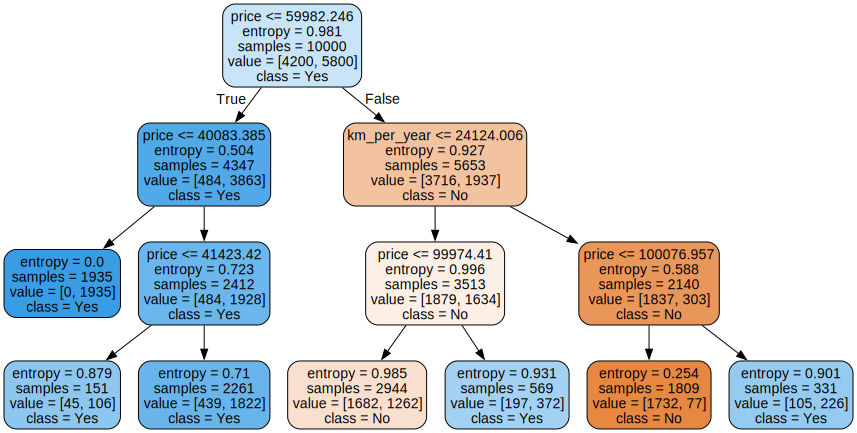

In [4]:
# Let's visualize the tree
import graphviz
from sklearn.tree import export_graphviz

best_estimator = search.best_estimator_
features = x_bad.columns
dot_data = export_graphviz(best_estimator, out_file=None, filled=True, rounded=True, class_names=['No', 'Yes'], feature_names=features)
graph = graphviz.Source(dot_data)
graph

# Customizing hyperparameters space

In [5]:
from scipy.stats import randint

# Let's modify the parameters space
parameters_space = {
    'max_depth': [3, 5, 10, 15, 20, 30, None],
    'min_samples_split': randint(32, 128),
    'min_samples_leaf': randint(32, 128),
    'criterion': ['gini', 'entropy']
}
search2, results2 = random_search(parameters_space, n_iter=16, estimator=DecisionTreeClassifier())
results2.head()
# At this time we explored a wider space, but with only a few samples

Scores (cross_val_score): 
Mean accuracy: 78.66
Confidence interval: [77.77, 79.55]
Best estimator: 
DecisionTreeClassifier(max_depth=3, min_samples_leaf=70, min_samples_split=49)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009732,0.000434,0.000807,0.000132,gini,15,124,46,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7795,0.7705,0.7795,0.7865,0.7845,0.7801,0.005535,6
1,0.011652,0.000328,0.000758,0.000067,gini,20,52,114,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7690,0.7635,0.7650,0.7765,0.7755,0.7699,0.005305,15
2,0.009652,0.000195,0.000683,0.000030,gini,10,106,119,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7745,0.7735,0.7835,0.7865,0.7830,0.7802,0.005212,5
3,0.011482,0.000209,0.000730,0.000024,gini,15,55,34,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7710,0.7600,0.7575,0.7785,0.7740,0.7682,0.008115,16
4,0.014751,0.000265,0.000737,0.000041,entropy,20,33,119,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.7680,0.7670,0.7700,0.7785,0.7810,0.7729,0.005731,13


In [6]:
# Let's see the results from best mean test score to worst
def show_best_results(results):
    best_results_ordered = results.sort_values('mean_test_score', ascending=False)
    print('Mean test score and Standard deviation:')
    for i, line in best_results_ordered.iterrows():
        print(f"{line.mean_test_score:.3f} +/-({line.std_test_score*2:.3f}) => {line.params}")

show_best_results(results2)
# Below we can see the mean test score, it's respective standard deviation and the parameters that generated those results
# These results are from the 16 iterations that we choose before on the RandomizedSearchCV

Mean test score and Standard deviation:
0.787 +/-(0.007) => {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 70, 'min_samples_split': 49}
0.787 +/-(0.007) => {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 91, 'min_samples_split': 45}
0.785 +/-(0.006) => {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 40, 'min_samples_split': 121}
0.784 +/-(0.008) => {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 53, 'min_samples_split': 120}
0.780 +/-(0.010) => {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 106, 'min_samples_split': 119}
0.780 +/-(0.011) => {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 124, 'min_samples_split': 46}
0.778 +/-(0.019) => {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 91, 'min_samples_split': 111}
0.778 +/-(0.019) => {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 93, 'min_samples_split': 78}
0.778 +/-(0.013) => {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 

In [7]:
# Now let's try more than 16 iterations, specifically, 4 times more
parameters_space = {
    'max_depth': [3, 5, 10, 15, 20, 30, None],
    'min_samples_split': randint(32, 128),
    'min_samples_leaf': randint(32, 128),
    'criterion': ['gini', 'entropy']
}
search3, results3 = random_search(parameters_space=parameters_space, n_iter=64, estimator=DecisionTreeClassifier())
results3.head()

Scores (cross_val_score): 
Mean accuracy: 78.68
Confidence interval: [77.45, 79.91]
Best estimator: 
DecisionTreeClassifier(max_depth=3, min_samples_leaf=70, min_samples_split=49)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009918,0.000160,0.000890,0.000114,gini,15,124,46,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7795,0.7705,0.7795,0.7865,0.7845,0.7801,0.005535,23
1,0.011544,0.000274,0.000729,0.000068,gini,20,52,114,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7690,0.7635,0.7650,0.7765,0.7755,0.7699,0.005305,61
2,0.009644,0.000186,0.000682,0.000058,gini,10,106,119,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7745,0.7735,0.7835,0.7865,0.7830,0.7802,0.005212,21
3,0.011510,0.000129,0.000736,0.000053,gini,15,55,34,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7710,0.7600,0.7575,0.7785,0.7740,0.7682,0.008115,64
4,0.014738,0.000213,0.000731,0.000059,entropy,20,33,119,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.7680,0.7670,0.7700,0.7785,0.7810,0.7729,0.005731,55


In [8]:
# See the ordered results again
show_best_results(results3)
# The best result was the same as before, so exploring more samples didn't give us any improvements

Mean test score and Standard deviation:
0.787 +/-(0.007) => {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 79, 'min_samples_split': 54}
0.787 +/-(0.007) => {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 119, 'min_samples_split': 32}
0.787 +/-(0.007) => {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50, 'min_samples_split': 33}
0.787 +/-(0.007) => {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 103, 'min_samples_split': 43}
0.787 +/-(0.007) => {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 33}
0.787 +/-(0.007) => {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 91, 'min_samples_split': 45}
0.787 +/-(0.007) => {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 70, 'min_samples_split': 49}
0.787 +/-(0.007) => {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 83, 'min_samples_split': 93}
0.787 +/-(0.007) => {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 93, 'min_sample

# Comparing GridSearchCV and RandomizedSearchCV

Now let's do a simple test to see if RandomizedSearchCV really is better than GridSearchCV

In [9]:
# Running with grid search

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

# The search will happen over the combination of all parameters
# Parameter space for GridSearchCV
# We added n_estimators and bootstrap parameters
parameters_space = {
    'n_estimators': [10, 100],
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Start counting time
tic = time.time()
# Until now we were using DecisionTreeClassifier, now let's try with RandomForestClassifier
search4 = GridSearchCV(RandomForestClassifier(), parameters_space, cv=KFold(n_splits=5, shuffle=True))
search4.fit(x_bad, y_bad)
tac = time.time()
elapsed_time = tac - tic
# Show elapsed time to do the search
print(f"Elapsed time: {elapsed_time:.2f} seconds")

results4 = pd.DataFrame(search4.cv_results_)
results4.head()

Elapsed time: 98.69 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019005,0.000724,0.001511,0.000045,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7765,0.7770,0.7725,0.768,0.7640,0.7716,0.004994,107
1,0.170362,0.002757,0.008304,0.000391,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7770,0.7750,0.779,0.7390,0.7683,0.014858,117
2,0.018747,0.001068,0.001562,0.000111,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7705,0.7525,0.7755,0.772,0.7630,0.7667,0.008189,124
3,0.172759,0.001542,0.008137,0.000097,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7660,0.7775,0.7755,0.779,0.7670,0.7730,0.005431,92
4,0.017410,0.000381,0.001451,0.000038,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7765,0.7285,0.7765,0.754,0.7395,0.7550,0.019329,142


In [10]:
show_best_results(results4)

Mean test score and Standard deviation:
0.779 +/-(0.008) => {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 32, 'n_estimators': 10}
0.779 +/-(0.007) => {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +/-(0.016) => {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 128, 'min_samples_split': 128, 'n_estimators': 10}
0.777 +/-(0.015) => {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.777 +/-(0.009) => {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.777 +/-(0.006) => {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 32, 'n_estimators': 100}
0.777 +/-(0.009) => {'bootstrap': False, 'criterion': 'gini', '

In [11]:
# Run cross validation score

#tic = time.time()
#scores = cross_val_score(search4, x_bad, y_bad, cv=KFold(n_splits=5, shuffle=True))
#tac = time.time()
#elapsed_time = tac - tic
#print(f"Elapsed time: {elapsed_time:.2f} seconds")

#print('Scores: ')
#print_score(scores)
#best_estimator = search4.best_estimator_
#print(best_estimator)

# This cell took 7m 35s
# The mean accuracy was 77.38
# Confidence interval: [76.08, 78.68]
# RandomForestClassifier(max_depth=5, min_samples_leaf=64, min_samples_split=128, n_estimators=10)

In [12]:
# Running with random search
# This parameter space has 140 possible combinations, on GridSearchCV we explore all of them
# but here, with RandomizedSearchCV, we explore only 20 (n_iter bellow)
parameters_space = {
    'n_estimators': [10, 100],
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Start counting time
tic = time.time()
# Until now we were using DecisionTreeClassifier, now let's try with RandomForestClassifier
search5, results5 = random_search(parameters_space=parameters_space, estimator=RandomForestClassifier(), n_iter=20)
tac = time.time()
elapsed_time = tac - tic
# Show elapsed time to do the search
print(f"Elapsed time: {elapsed_time:.2f} seconds")
results5.head()

# This execution with RandomizedSearchCV (including the cross_val_score) took 1m 14s, while GridSearchCV took 1m 39s

# If we ware to use all the values in a certain interval for the parameters of the parameter space, the execution time with GridSearchCV would very long. But with RandomizedSearchCV we can explore all the range of values executing train and test for a limited number of samples of all the combinations of parameters.

# Also, we can use n_iter to choose how many time we want to run the search. We have more control over the consumption of computing resources. If we want, we can run it for 50, 100 iterations.

Scores (cross_val_score): 
Mean accuracy: 77.40
Confidence interval: [74.49, 80.31]
Best estimator: 
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=64,
                       min_samples_split=128, n_estimators=10)
Elapsed time: 73.04 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.237519,0.007538,0.008293,0.000072,100,64,64,3,entropy,False,"{'n_estimators': 100, 'min_samples_split': 64,...",0.7765,0.7745,0.7735,0.7795,0.7715,0.7751,0.002728,8
1,0.230180,0.002084,0.009992,0.000073,100,32,32,5,gini,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7745,0.7750,0.7730,0.7845,0.7750,0.7764,0.004116,3
2,0.021594,0.001484,0.001544,0.000037,10,128,64,3,gini,False,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7800,0.7515,0.7430,0.7790,0.7590,0.7625,0.014778,20
3,0.291101,0.003740,0.010179,0.000078,100,32,64,5,gini,False,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7765,0.7720,0.7720,0.7795,0.7710,0.7742,0.003265,12
4,0.026518,0.000955,0.001660,0.000059,10,64,32,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7785,0.7820,0.7650,0.7820,0.7670,0.7749,0.007405,11


In [13]:
show_best_results(results5)
# This time our best result was 77.6 and our last search was 78.68, so changing to RandomForestClassifier decreased accuracy in 1% for this particular parameter space configuration

Mean test score and Standard deviation:
0.779 +/-(0.013) => {'n_estimators': 10, 'min_samples_split': 128, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.778 +/-(0.019) => {'n_estimators': 10, 'min_samples_split': 128, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 +/-(0.008) => {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}
0.776 +/-(0.008) => {'n_estimators': 100, 'min_samples_split': 128, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +/-(0.014) => {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
0.776 +/-(0.007) => {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}
0.775 +/-(0.005) => {'n_estimators': 100, 'min_samples_split': 32, 'm

# Without using cross validation for fitting

In [16]:
# As we'll not use nested cross validation we need to separate part of the data for validation, to be used after the fitting process.
# Let's do the following data configuration:
# 60% for training, 20% for test and 20% for validation

from sklearn.model_selection import train_test_split

x_train_test, x_validation, y_train_test, y_validation = train_test_split(x_bad, y_bad, test_size=0.2, shuffle=True, stratify=y_bad)
print(x_train_test.shape, x_validation.shape, y_train_test.shape, y_validation.shape)
# On x we have the features and on y we have the class

(8000, 3) (2000, 3) (8000,) (2000,)


In [19]:
# Now we'll use StratifiedShuffleSplit rather than KFold to split the data

from sklearn.model_selection import StratifiedShuffleSplit

parameters_space = {
    'n_estimators': [10, 100],
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Dividing the data into just one block of train and test
# The percentage of the test data is 20% of the 80% = 25% of the total amount of data, the remaining 20% will be kept for validation as new data, never seen before by the model
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25)

tic = time.time()
search6 = RandomizedSearchCV(RandomForestClassifier(), parameters_space, cv=split)
# Now, rather than x_bad, y_bad we'll use x_train_test and y_train_test
search6.fit(x_train_test, y_train_test)
tac = time.time()
elapsed_time = tac-tic
print(f"Elapsed time: {elapsed_time:.2f} seconds")

results6 = pd.DataFrame(search6.cv_results_)
results6.head()

Elapsed time: 1.15 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.042014,0.0,0.002423,0.0,10,32,64,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7750,0.7750,0.0,1
1,0.199928,0.0,0.008473,0.0,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7695,0.7695,0.0,5
2,0.019417,0.0,0.001598,0.0,10,64,64,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7340,0.7340,0.0,10
3,0.024985,0.0,0.001777,0.0,10,128,32,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7615,0.7615,0.0,9
4,0.018714,0.0,0.001469,0.0,10,128,128,3,entropy,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7700,0.7700,0.0,3


In [20]:
# Finally, lets validate the model
# The validation is with the validation data
scores = cross_val_score(search6, x_validation, y_validation, cv=split)
print_score(scores)
best_estimator2 = search6.best_estimator_
best_estimator2
# Now we have just one accuracy value, therefore we lost the measure of the confidence interval

Mean accuracy: 76.80
Confidence interval: [76.80, 76.80]


RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=64,
                       min_samples_split=32, n_estimators=10)

In [ ]:
# In summary: exploring possible model configurations with more than one split is costly, but gives us a wider view of the possible results that the model can achieve. Using just one split with train, test and validation for data separation is simpler, faster and uses less resources, but you'l have a narrow view of how the model behaves.